In [1]:
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.datasets import load_digits
import matplotlib.pyplot  as plt
import numpy as np 

In [2]:
class TSNE:
    
    def __init__(self, alpha = 800, momentum = 0.5 , n_feauture = 2, perpelixity = 60,  max_iter = 500):
        self.alpha = alpha
        self.n_feauture= n_feauture
        self.max_iter= max_iter
        self.perpelixity = perpelixity
        
    def do_P(self,X):
        sigmas = self.determine_sigmas(pairwise_distances(X), self.perpelixity)
        probabilities = self.compute_probabilities(pairwise_distances(X), sigmas)
        return (probabilities + probabilities.T) / (2. * X.shape[0])
    
    def do_Q(self,y):
        q = 1 / (1 +  pairwise_distances(y))
        np.fill_diagonal(q, 0.)
        return q / np.sum(np.sum(q))
        
    def entropy(self, matrix):
        return 2 ** (-np.sum(matrix * np.log2(matrix), axis=1))
    
    def compute_probabilities(self, distances, sigmas):
        exponent = np.exp(-distances / (2 * np.square(sigmas.reshape((-1, 1)))))
        np.fill_diagonal(exponent, 0.)
        exponent += 1e-10
        return exponent / np.sum(exponent, axis=1, keepdims=True)
    
    def determine_sigmas(self, distances, perplexity):
        founded  = np.zeros(distances.shape[0])
        for i in range(distances.shape[0]):
            func = lambda sig: self.entropy(self.compute_probabilities(distances[i:i+1, :], np.array([sig])))
            founded[i] = self.binary_search(func, perplexity)
        return founded
    
    def binary_search(self, func, goal, tol=1e-10, max_iters=500, lower_bound=1e-20, upper_bound=10000):
        for _ in range(max_iters):
            guess = (upper_bound + lower_bound) / 2.
            val = func(guess)

            if val > goal:
                upper_bound = guess
            else:
                lower_bound = guess

            if np.abs(val - goal) <= tol:
                return guess
        return guess
    
    def momentum(self,t):
        return 0.04 if t < 250 else 0.07

    def fit(self, X):
        D = pairwise_distances(X)
        p = self.do_P(X) 
        y =np.random.rand(D.shape[0] , self.n_feauture )
        a = [np.zeros( (D.shape[0] , self.n_feauture) ) ]

        for i in range(self.max_iter):
            q = self.do_Q(y)
            vector = y[:, np.newaxis, :] - y[np.newaxis, :, :]
            cost =  4 * np.sum( (p-q) * vector.T *  (1 / (1 + pairwise_distances(y)) ), axis = 1 ).T
            y = y - self.alpha * cost  + self.momentum(i)* (y  - a[0])
            a.append(y)
            a.remove(a[0])
        return (y)
        

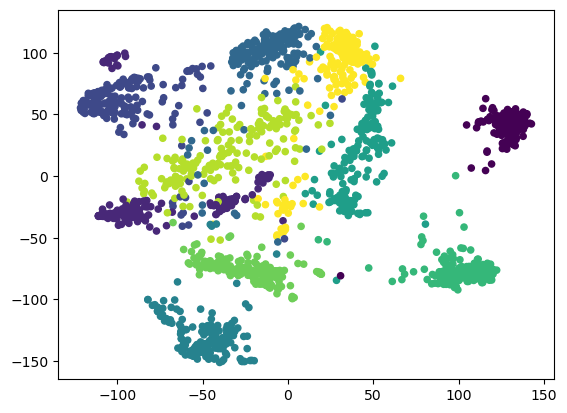

In [3]:
from sklearn.datasets import load_digits
import matplotlib.pyplot  as plt

X, y = load_digits(return_X_y=True)
res = TSNE()
a = res.fit(X)
plt.scatter(a[:, 0], a[:, 1], s=20, c=y)
plt.show()